In [18]:
from sena.data.norec.dataloader import load_full_dataset
import sena.utils.preprocessing as preprocessing
import pandas as pd

NameError: name '__file__' is not defined

In [2]:
# Loading data
data = load_full_dataset()

train = data["train"]
val = data["dev"]
test = data["test"]

# Shuffling data
train = train.sample(frac=1).reset_index(drop=True)
val = val.sample(frac=1).reset_index(drop=True)
test = test.sample(frac=1).reset_index(drop=True)

# Cleaning values in the text column
train = preprocessing.clean_text(train, "text")
val = preprocessing.clean_text(val, "text")
test = preprocessing.clean_text(test, "text")

# Combining data for later use
combined_data = pd.concat([train, val, test]).reset_index(drop=True)

In [3]:
combined_data.head()

,text,label
0,ashanticoncret ros mercuryuniversal ashantis t...,0
1,abrupt pompøst uengasjer manus madonn alek kes...,1
2,mor far bestemm gret poetisk fabel bygd brødr ...,2
3,strokesroom fir rcabmg gjentag room fir strok ...,2
4,every thing fin langsomt dvel forsoning liv tr...,2


In [4]:
from collections import Counter
import math

num_words = Counter()
for review in combined_data["text"]:
    for word in review.split(" "):
        num_words[word] += 1

# Deciding the vocabulary size
num_words = len(num_words) / 20
num_words = math.ceil(num_words / 1000) * 1000
print("Number of words:", num_words)

Number of words: 20000


In [5]:
average_text_length = combined_data["text"].str.len().mean()
max_text_length = combined_data["text"].str.len().max()

print("Average text length:", int(average_text_length))
print("Max text length:", int(max_text_length))

Average text length: 1431
Max text length: 12588


In [6]:
from keras.utils.np_utils import to_categorical
from keras.preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences
import numpy as np

# Separating texts and labels
X_train, y_train = train["text"], train["label"]
X_val, y_val = val["text"], val["label"]
X_test, y_test = test["text"], test["label"]

# Fitting a tokenizer to text from the combined data
tokenizer = Tokenizer(num_words=num_words, oov_token="<OOV>")
tokenizer.fit_on_texts(combined_data["text"].tolist())

# Converting texts to sequences
X_train = tokenizer.texts_to_sequences(X_train)
X_val = tokenizer.texts_to_sequences(X_val)
X_test = tokenizer.texts_to_sequences(X_test)

In [7]:
# Deciding embedding vector length
maxlen = (int(np.ceil(np.mean([len(text.split()) for text in combined_data.text]))))

# Padding sequences with zeros until they reach a certain length
X_train = pad_sequences(X_train, maxlen=maxlen)
X_val = pad_sequences(X_val, maxlen=maxlen)
X_test = pad_sequences(X_test, maxlen=maxlen)

In [8]:
num_classes = len(np.unique(y_train))
print("Number of classes:", num_classes)

# One-hot encoding of labels
y_train = to_categorical(y_train, num_classes=num_classes)
y_val = to_categorical(y_val, num_classes=num_classes)
y_test = to_categorical(y_test, num_classes=num_classes)

Number of classes: 3


In [9]:
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape, end="\n\n")
print("X_val shape:", X_val.shape)
print("y_val shape:", y_val.shape, end="\n\n")
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

X_train shape: (34903, 210)
y_train shape: (34903, 3)

X_val shape: (4360, 210)
y_val shape: (4360, 3)

X_test shape: (4351, 210)
y_test shape: (4351, 3)


In [10]:
import itertools

# 10 most common words in the vocabulary
dict(itertools.islice(tokenizer.word_index.items(), 10))

{'<OOV>': 1,
 'film': 2,
 'gjør': 3,
 'litt': 4,
 'får': 5,
 'komm': 6,
 'spill': 7,
 'først': 8,
 'helt': 9,
 'stor': 10}

In [11]:
from keras.regularizers import l1_l2
from keras.models import Sequential
from keras.layers import Dense, LSTM, Embedding, Bidirectional, SpatialDropout1D
from keras.optimizers import adam_v2

models = []
lstm_nodes = 32

In [12]:
baseline_model = Sequential(name="baseline")
baseline_model.add(Embedding(num_words, 100, input_length=maxlen))
baseline_model.add(Bidirectional(LSTM(lstm_nodes)))
baseline_model.add(Dense(num_classes, activation='softmax'))

baseline_model.compile(loss="categorical_crossentropy", optimizer=adam_v2.Adam(learning_rate=0.001), metrics=["accuracy"])
baseline_model.summary()

models.append(baseline_model)

Model: "baseline"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 210, 100)          2000000   
                                                                 
 bidirectional (Bidirectiona  (None, 64)               34048     
 l)                                                              
                                                                 
 dense (Dense)               (None, 3)                 195       
                                                                 
Total params: 2,034,243
Trainable params: 2,034,243
Non-trainable params: 0
_________________________________________________________________


In [13]:
model_1 = Sequential(name="baseline-dropout")
model_1.add(Embedding(num_words, 100, input_length=maxlen))
model_1.add(SpatialDropout1D(0.4))
model_1.add(Bidirectional(LSTM(lstm_nodes, recurrent_dropout=0.4, dropout=0.4)))
model_1.add(Dense(num_classes, activation='softmax'))

model_1.compile(loss="categorical_crossentropy", optimizer=adam_v2.Adam(learning_rate=0.001), metrics=["accuracy"])
model_1.summary()

models.append(model_1)

Model: "baseline-dropout"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 210, 100)          2000000   
                                                                 
 spatial_dropout1d (SpatialD  (None, 210, 100)         0         
 ropout1D)                                                       
                                                                 
 bidirectional_1 (Bidirectio  (None, 64)               34048     
 nal)                                                            
                                                                 
 dense_1 (Dense)             (None, 3)                 195       
                                                                 
Total params: 2,034,243
Trainable params: 2,034,243
Non-trainable params: 0
_________________________________________________________________


In [14]:
model_2 = Sequential(name="baseline-regularization")
model_2.add(Embedding(num_words, 100, input_length=maxlen))
model_2.add(Bidirectional(LSTM(lstm_nodes, recurrent_regularizer=l1_l2(0.0003), kernel_regularizer=l1_l2(0.0003))))
model_2.add(Dense(num_classes, activation='softmax'))

model_2.compile(loss="categorical_crossentropy", optimizer=adam_v2.Adam(learning_rate=0.001), metrics=["accuracy"])
model_2.summary()

models.append(model_2)

Model: "baseline-regularization"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 210, 100)          2000000   
                                                                 
 bidirectional_2 (Bidirectio  (None, 64)               34048     
 nal)                                                            
                                                                 
 dense_2 (Dense)             (None, 3)                 195       
                                                                 
Total params: 2,034,243
Trainable params: 2,034,243
Non-trainable params: 0
_________________________________________________________________


In [15]:
model_3 = Sequential(name="baseline-dropout-regularization")
model_3.add(Embedding(num_words, 100, input_length=maxlen))
model_3.add(SpatialDropout1D(0.4))
model_3.add(Bidirectional(LSTM(lstm_nodes, recurrent_dropout=0.4, dropout=0.4,
                               recurrent_regularizer=l1_l2(0.0003),
                               kernel_regularizer=l1_l2(0.0003))))
model_3.add(Dense(num_classes, activation='softmax'))

model_3.compile(loss="categorical_crossentropy", optimizer=adam_v2.Adam(learning_rate=0.001), metrics=["accuracy"])
model_3.summary()

models.append(model_3)

Model: "baseline-dropout-regularization"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 210, 100)          2000000   
                                                                 
 spatial_dropout1d_1 (Spatia  (None, 210, 100)         0         
 lDropout1D)                                                     
                                                                 
 bidirectional_3 (Bidirectio  (None, 64)               34048     
 nal)                                                            
                                                                 
 dense_3 (Dense)             (None, 3)                 195       
                                                                 
Total params: 2,034,243
Trainable params: 2,034,243
Non-trainable params: 0
_________________________________________________________________


In [16]:
from keras.callbacks import EarlyStopping
from datetime import datetime

callbacks = [EarlyStopping(monitor="val_accuracy", patience=3),
             EarlyStopping(monitor="val_loss", patience=3)]

epochs = 20
batch_size = 16

histories = {}

for model in models:
    print(f"\n--------------- Training model: {model.name} ---------------")
    history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_val, y_val),
                        verbose=1,
                        callbacks=callbacks)

    val_loss, val_acc = model.evaluate(X_test, y_test, verbose=1)
    print("Validation loss:", val_loss)
    print("Validation accuracy:", val_acc)

    if val_acc > 0.8:
        print(f"Saving model {model.name} ...")
        model_name = f"models/SA-LSTM-MULTICLASS-{model.name}-{val_acc}-{datetime.now().strftime('%Y%m%d')}.h5"
        model.save(model_name)

    histories[model.name] = history

    print(f"----------- Finished training model: {model.name} -----------\n")


--------------- Training model: baseline ---------------
Epoch 1/20
1091/1091 [==============================] - 117s 104ms/step - loss: 0.5903 - accuracy: 0.7679 - val_loss: 0.4908 - val_accuracy: 0.8037
Epoch 2/20
1091/1091 [==============================] - 115s 105ms/step - loss: 0.4088 - accuracy: 0.8323 - val_loss: 0.4981 - val_accuracy: 0.8023
Epoch 3/20
1091/1091 [==============================] - 117s 107ms/step - loss: 0.2664 - accuracy: 0.8979 - val_loss: 0.6687 - val_accuracy: 0.8028
Epoch 4/20
136/136 [==============================] - 4s 32ms/step - loss: 0.7361 - accuracy: 0.7787
Validation loss: 0.736052393913269
Validation accuracy: 0.7786715626716614
----------- Finished training model: baseline -----------


--------------- Training model: baseline-dropout ---------------
Epoch 1/20
1091/1091 [==============================] - 265s 239ms/step - loss: 0.6274 - accuracy: 0.7570 - val_loss: 0.5549 - val_accuracy: 0.7537
Epoch 2/20
1091/1091 [===========================

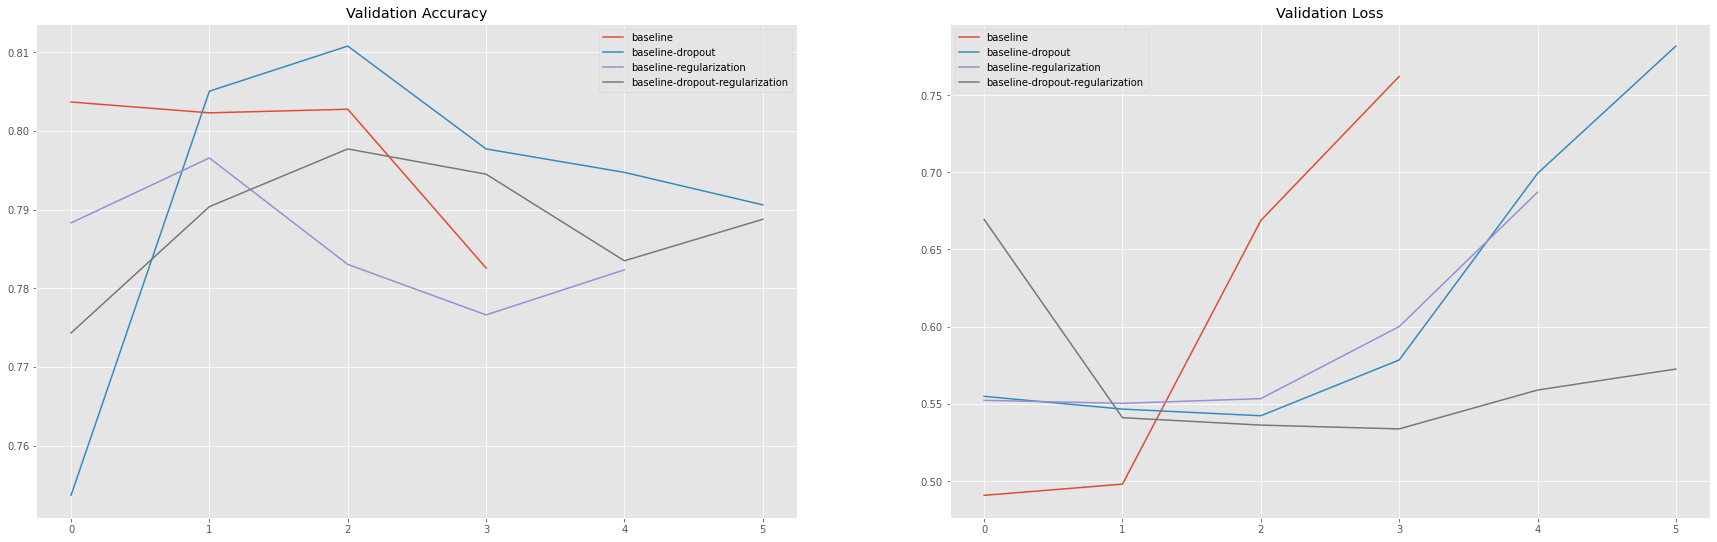

<Figure size 432x288 with 0 Axes>

In [17]:
from sena.utils.visualization import plot_histories

plot_histories(histories, plot_name=f"SA-BiLSTM{lstm_nodes}-NOREC-FULL-MULTICLASS-HISTORIES")